# notebook for implementing re_sc algorithms and comparing the results


***
Importing packages 
***

In [18]:
import numpy as np              
import pandas as pd              

import scipy.stats as stats   

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neighbors import NearestNeighbors, KDTree               
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier   

from sklearn.metrics import roc_auc_score, recall_score, f1_score, confusion_matrix   
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE 
from imblearn.combine import SMOTETomek, SMOTEENN 

import matplotlib.pyplot as plt
import seaborn as sns

from data.store import load_datasets_csv


import warnings

# Suppress warnings for clean output
warnings.filterwarnings('ignore')

***
Function for calculating size of Set_N
***

In [4]:
def calculate_set_n_size_re_sc(X_maj, n_min, alpha=0.05, epsilon=0.05, M=1.5):
    """
    Calculates the size of the majority subset |Set_N| based on Eqs. 3, 4, and 5.
    
    Parameters:
    -----------
    X_maj : array-like or pd.DataFrame
        The feature matrix of the majority class samples (used to calc sigma).
    n_min : int
        Number of minority samples (|P|).
    alpha : float, optional (default=0.05)
        Significance level for the Z-test (e.g., 0.05 for 95% confidence).
    epsilon : float, optional (default=0.05)
        Acceptable tolerance error.
    M : float, optional (default=1.5)
        Imbalance Ratio threshold for the concatenated dataset.
        
    Returns:
    --------
    int
        The calculated size of |Set_N|.
    """

    n_maj = len(X_maj)
    
    n1 = (n_min ** 2) / n_maj

    if isinstance(X_maj, pd.DataFrame):
        X_vals = pd.get_dummies(X_maj, drop_first=True).astype(float).values
    else:
        try:
            X_vals = np.array(X_maj, dtype=float)
        except:
            X_vals = pd.get_dummies(pd.DataFrame(X_maj), drop_first=True).astype(float).values
        
    z_score = stats.norm.ppf(1 - alpha / 2)
    sigma = np.std(X_vals)
    z_sq = z_score ** 2
    sigma_sq = sigma ** 2
    epsilon_sq = epsilon ** 2
    numerator = n_maj * z_sq * sigma_sq # if z_sq / sigma_sq / N lower than current, could improve n2
    denominator = (n_maj * epsilon_sq) + (z_sq * sigma_sq) # if epsilon_sq higher, could improve n2 
    n2 = numerator / denominator

    if n1 == 0: 
        return int(n2)
        
    Pr = n2 / n1

    if Pr < 1:
        set_n_size = n1
    elif 1 <= Pr <= M:
        set_n_size = n2
    else: # Pr > M
        set_n_size = M * n1
        
    return int(np.ceil(set_n_size))

***
Function for sampling Set_N using ramndom wheighted choise 
***

In [5]:
def get_set_n_random_weighted_re_sc(X, y, n_size, k=5):
    """
    Parameters:
    -----------
    X : pd.DataFrame or np.array
        The full training feature matrix.
    y : pd.Series or np.array
        The full training target vector (Minority=+1, Majority=-1).
    n_size : int
        The number of samples to select for Set_N (calculated previously).
    k : int, optional (default=5)
        Number of neighbors for weight calculation.

    Returns:
    --------
    X_set_n : pd.DataFrame/np.array
        The selected majority samples.
    """
    if isinstance(X, pd.DataFrame):
        X_original = X
        X_numeric = pd.get_dummies(X, drop_first=True).astype(float).values
        X_index = X.index
    else:
        X_original = X
        try:
            X_numeric = np.array(X, dtype=float)
        except:
            X_numeric = pd.get_dummies(pd.DataFrame(X), drop_first=True).astype(float).values
        X_index = np.arange(len(X))
        
        
    if isinstance(y, pd.Series):
        y_vals = y.values
    else:
        y_vals = y

    maj_mask = (y_vals == -1)
    maj_indices = np.where(maj_mask)[0]
    
    X_mean = np.mean(X_numeric, axis=0)
    X_std = np.std(X_numeric, axis=0)
    X_std[X_std == 0] = 1.0 
    X_norm = (X_numeric - X_mean) / X_std
    
    knn = NearestNeighbors(n_neighbors=k+1).fit(X_norm)
    
    weights = []
    valid_indices = [] 
    
    X_maj_norm = X_norm[maj_indices]
    distances, neighbor_idxs = knn.kneighbors(X_maj_norm)
    
    for i, n_idxs in enumerate(neighbor_idxs):
        actual_neighbors = n_idxs[1:]
        
        maj_neighbor_count = np.sum(y_vals[actual_neighbors] == -1)
        
        weight = maj_neighbor_count / k

        #if weigth is 0, sample won't be added to 
        if weight > 0:
            weights.append(weight)
            valid_indices.append(maj_indices[i])
            
    weights = np.array(weights)
    valid_indices = np.array(valid_indices)
    
    if len(weights) == 0:
        raise ValueError("No valid majority samples found (all are surrounded by minority class).")
        
    probs = weights / np.sum(weights)
    
    # Handle case where calculated n_size > available valid samples
    actual_n_size = min(n_size, len(valid_indices))
    
    selected_indices = np.random.choice(
        valid_indices, 
        size=actual_n_size, 
        replace=False, 
        p=probs
    )
    
    if isinstance(X, pd.DataFrame):
        return X.loc[X_index[selected_indices]]
    else:
        return X[selected_indices]

***
Function helper for creating concatenated dataset Re_Sc
***

In [6]:
def re_sc_concatenation(X_min, X_maj, X_set_n):
 
    def to_numpy(data):
        return data.values if isinstance(data, (pd.DataFrame, pd.Series)) else data

    P = to_numpy(X_min)      
    N = to_numpy(X_maj)      
    Set_N = to_numpy(X_set_n) 
    
    m = len(P)
    
    # Example for m=2: [p1, p2]
    # repeat -> [p1, p1, p2, p2]
    # tile   -> [p1, p2, p1, p2]
    # concat -> [p1p1, p1p2, p2p1, p2p2]
    
    P_repeat = np.repeat(P, m, axis=0)
    P_tile = np.tile(P, (m, 1))
    P_c = np.hstack([P_repeat, P_tile]) 
    
    y_p_c = np.ones(len(P_c))

    M = len(N)
    k = len(Set_N)
    
    if k > 0:
        N_repeat = np.repeat(N, k, axis=0)  
        Set_N_tile = np.tile(Set_N, (M, 1)) 
        N_c = np.hstack([N_repeat, Set_N_tile])
        
        y_n_c = -1 * np.ones(len(N_c))
        
        X_c_array = np.vstack([P_c, N_c])
        y_c_array = np.hstack([y_p_c, y_n_c])
    else:
        X_c_array = P_c
        y_c_array = y_p_c

    original_cols = range(P.shape[1])
    new_cols = [f"f{i}_A" for i in original_cols] + [f"f{i}_B" for i in original_cols]
    
    return pd.DataFrame(X_c_array, columns=new_cols), pd.Series(y_c_array, name="target")

***
Baseline of the algorithm
***

In [7]:
def alg_base(X, y, calculate_set_n_size, get_set_n, get_concat, alpha=0.05, epsilon=0.05, M=1.5, k=5):
    if isinstance(y, pd.Series):
        y = y.values
    
    X_min = X[y == 1]
    X_maj = X[y == -1]
    n_min = len(X_min)
    
    n_size = calculate_set_n_size(X_maj, n_min, alpha, epsilon, M)
    X_set_n = get_set_n(X, y, n_size, k)
    
    X_resampled, y_resampled = get_concat(X_min, X_maj, X_set_n)
    
    return X_resampled, y_resampled

***
Function for calculating complexity of the dataset
***

In [16]:
def calculate_complexity(X, y, k=5):
    """
    Calculates Maj_Com and Min_Com based on Eq. 15.
    Metric: Average proportion of k-nearest neighbors belonging to the same class.
    """
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
        
    X_encoded = pd.get_dummies(X, drop_first=True)
    X_encoded = X_encoded.astype(float)
    X_norm = (X_encoded - X_encoded.mean()) / X_encoded.std()
    X_norm = X_norm.fillna(0) 
    
    knn = NearestNeighbors(n_neighbors=k+1).fit(X_norm) # +1 because sample includes itself

    def get_class_complexity(target_class):
        class_indices = np.where(y == target_class)[0]
        if len(class_indices) == 0: return 0.0
        distances, indices = knn.kneighbors(X_norm.iloc[class_indices])
        
        neighbor_indices = indices[:, 1:]
        neighbor_labels = y.iloc[neighbor_indices.flatten()].values.reshape(neighbor_indices.shape)
        matches = (neighbor_labels == target_class).astype(int)
    
        return np.mean(np.mean(matches, axis=1))

    maj_com = get_class_complexity(-1)
    min_com = get_class_complexity(1)
    
    return maj_com, min_com

***
Function for outputing complexities of the datasets
***

In [8]:
def compare_complexities(datasets):
    results = []
    names = []
    
    for name, (X, y) in datasets.items():
        maj_c, min_c = calculate_complexity(X, y)
        results.append([maj_c, min_c])
        names.append(name)
    
    df_res = pd.DataFrame(results, columns=['Maj_Com', 'Min_Com'], index=names)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(names))
    width = 0.35
    
    rects1 = ax.bar(x - width/2, df_res['Maj_Com'], width, label='Maj_Com', color='blue')
    rects2 = ax.bar(x + width/2, df_res['Min_Com'], width, label='Min_Com', 
                    color='white', edgecolor='red', hatch='///')
    
    ax.set_ylabel('Data Complexity Measure')
    ax.set_title('Comparison of Majority and Minority Class Complexity')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylim(0, 1.05)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.clf()

In [11]:
synthetic_datasets=load_datasets_csv('../data/synthetic')

--- Loading datasets from '../data/synthetic/' ---


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 419.12it/s]

Loaded: synth_type1_1d_v1 | Shape: (1000, 1)
Loaded: synth_type1_1d_v2 | Shape: (1000, 1)
Loaded: synth_type1_2d_v1 | Shape: (1000, 2)
Loaded: synth_type1_2d_v2 | Shape: (1000, 2)
Loaded: synth_type1_3d_v1 | Shape: (1000, 3)
Loaded: synth_type1_3d_v2 | Shape: (1000, 3)
Loaded: synth_type2_2d | Shape: (1000, 2)
Loaded: synth_type2_2d_example | Shape: (1000, 2)


In [12]:
uci_datasets=load_datasets_csv('../data/uci_ml_processed')

--- Loading datasets from '../data/uci_ml_processed/' ---


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 391.86it/s]

Loaded: abalone9-18_processed | Shape: (731, 7)
Loaded: ecoli-0147vs56_processed | Shape: (332, 7)
Loaded: ecoli-01vs235_processed | Shape: (244, 7)
Loaded: ecoli-01vs5_processed | Shape: (240, 7)
Loaded: ecoli-0234vs5_processed | Shape: (202, 7)
Loaded: ecoli-046vs5_processed | Shape: (203, 7)
Loaded: ecoli-067vs5_processed | Shape: (220, 7)
Loaded: ecoli2_processed | Shape: (336, 7)
Loaded: ecoli3_processed | Shape: (336, 7)
Loaded: glass6_processed | Shape: (214, 9)
Loaded: haberman_processed | Shape: (306, 3)
Loaded: iris0_processed | Shape: (150, 4)
Loaded: page-blocks-13vs4_processed | Shape: (5029, 10)
Loaded: spect_processed | Shape: (267, 22)
Loaded: yeast-1vs7_processed | Shape: (459, 8)
Loaded: yeast-2vs4_processed | Shape: (514, 8)


In [13]:
datasets = {}
for key, (X, y) in uci_datasets.items():
    datasets[key] = (X, y)
for key, (X, y) in synthetic_datasets.items():
    datasets[key] = (X, y)

In [14]:
re_sc_random_weghted_choosing_dataset = {}
for key, (X, y) in datasets.items():
    X_resampled, y_resampled = alg_base(X, y, calculate_set_n_size_re_sc, get_set_n_random_weighted_re_sc, re_sc_concatenation)
    re_sc_random_weghted_choosing_dataset[key] = (X_resampled, y_resampled)

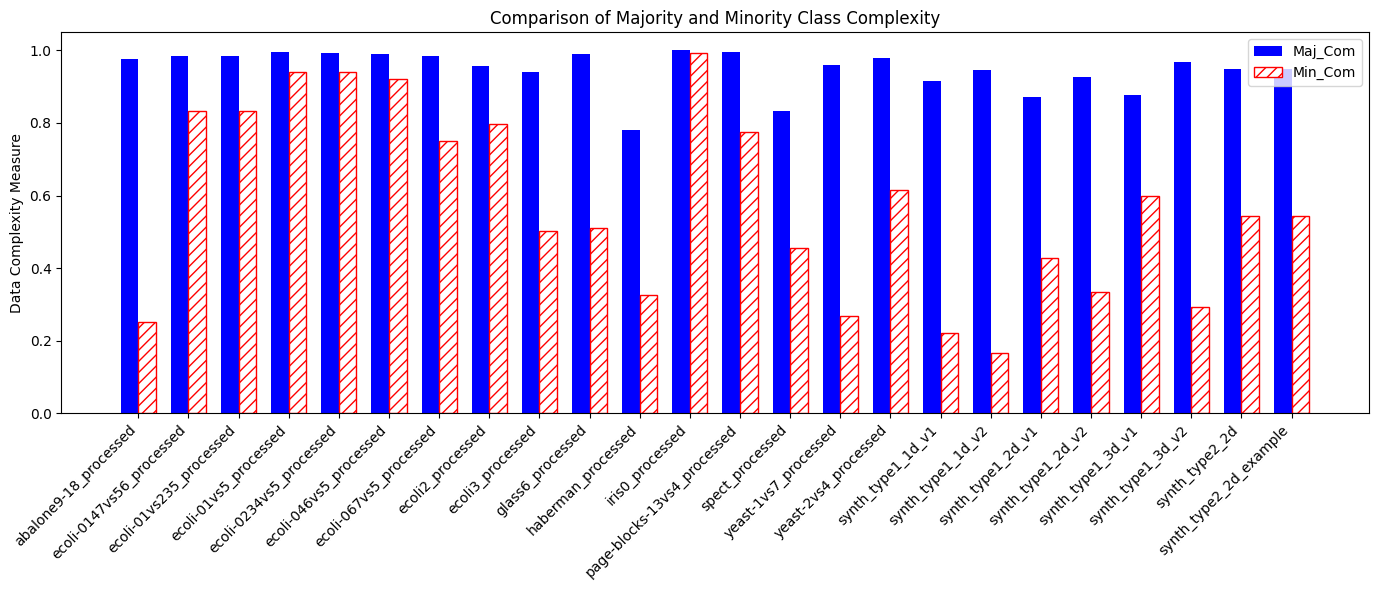

<Figure size 640x480 with 0 Axes>

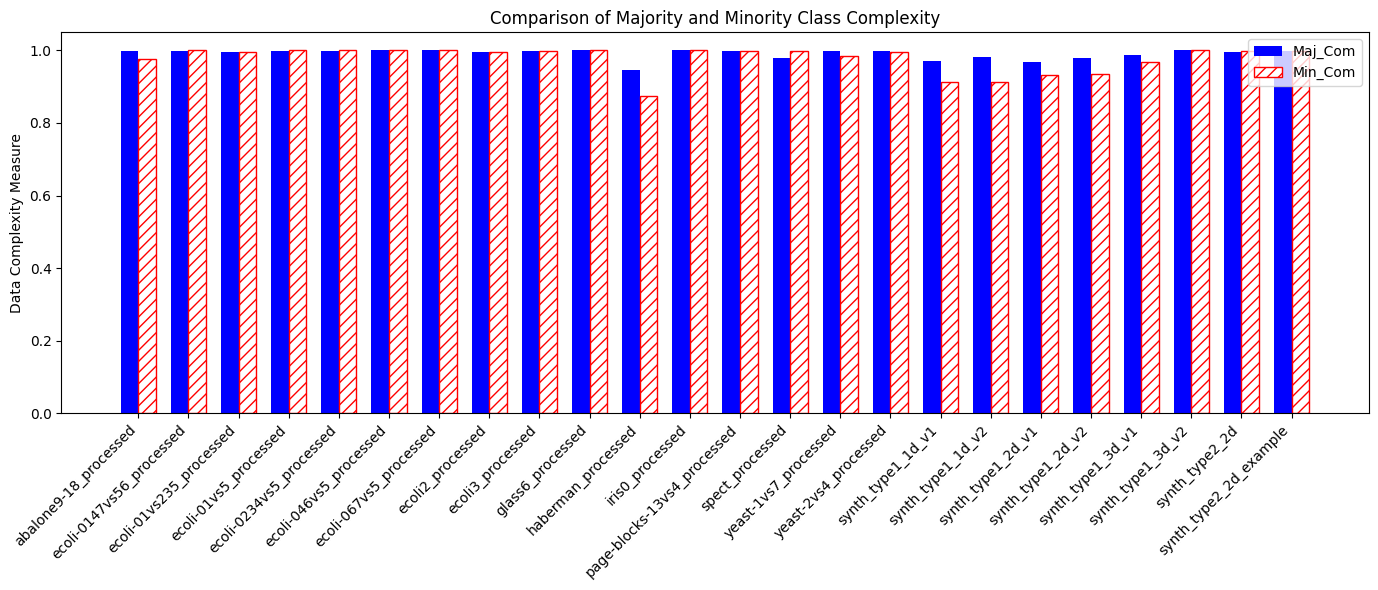

<Figure size 640x480 with 0 Axes>

In [19]:
compare_complexities(datasets)
compare_complexities(re_sc_random_weghted_choosing_dataset)

In [ ]:


# ==========================================
# 1. Metric Helper
# ==========================================
def calculate_g_mean(y_true, y_pred):
    """
    Calculates Geometric Mean (G-mean) as defined in Section 5.3.1:
    G-mean = sqrt(Sensitivity * Specificity)
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return np.sqrt(sensitivity * specificity)

# ==========================================
# 2. Classifier Configuration
# ==========================================
def get_classifier(n_features, n_classes=2):
    """
    Returns MLP as specified in Section 5.3.1:
    Single hidden layer, nodes = 2 * (input + output) / 3
    """
    n_input = n_features
    n_output = n_classes
    # Hidden layer size formula from the paper
    n_hidden = int(np.ceil(2 * (n_input + n_output) / 3))
    
    return MLPClassifier(hidden_layer_sizes=(n_hidden,), max_iter=500, random_state=42)

# ==========================================
# 3. Experiment Engine
# ==========================================
def run_experiments(datasets_dict, alg_base_func):
    """
    Runs 10x 10-Fold CV.
    Args:
        datasets_dict: Dictionary of {name: (X, y)}
        alg_base_func: User provided function that returns (X_resampled, y_resampled)
    """
    
    # Define Comparison Methods (Baselines from Paper Section 5.3.1)
    methods = {
        'Original': None,
        'SMOTE': SMOTE(k_neighbors=5, random_state=42),
        'SMOTE-TL': SMOTETomek(smote=SMOTE(k_neighbors=5), random_state=42),
        'SMOTE-ENN': SMOTEENN(smote=SMOTE(k_neighbors=5), random_state=42),
        'BL-SMOTE': BorderlineSMOTE(k_neighbors=5, kind='borderline-1', random_state=42),
        'ADASYN': ADASYN(n_neighbors=5, random_state=42),
        # 'CSMLP': Placeholder for Cost Sensitive Learning if needed
        'Re-SC': 'custom_func' # Tag to use your alg_base
    }
    
    # Storage for results
    results = {metric: {m: [] for m in methods} for metric in ['AUC', 'Recall', 'G-mean', 'F1']}
    dataset_names = []

    print(f"Starting Experiments on {len(datasets_dict)} datasets...")
    print("Protocol: 10 repeated 10-fold CV (Section 5.3.1).")

    for name, (X, y) in datasets_dict.items():
        print(f"Processing {name}...", end=" ")
        dataset_names.append(name)
        
        # 1. Preprocessing (Impute & Scale)
        # Essential for Neural Networks and Distance-based methods
        imputer = SimpleImputer(strategy='mean')
        scaler = StandardScaler()
        X_proc = scaler.fit_transform(imputer.fit_transform(X))
        y = y.astype(int).values # Ensure integer target
        
        # Local storage for this dataset
        ds_results = {m: {'AUC':[], 'Recall':[], 'G-mean':[], 'F1':[]} for m in methods}
        
        # 2. Cross Validation Strategy
        rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42) 
        
        for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X_proc, y)):
            X_train, X_test = X_proc[train_idx], X_proc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            for method_name, sampler in methods.items():
                try:
                    # --- A. Resampling Phase ---
                    if method_name == 'Re-SC':
                        # 1. Call YOUR function
                        X_res, y_res = alg_base_func(X_train, y_train)
                        
                        # 2. Transform Test Data (Crucial Step: x -> x,x)
                        # Section 3.2.2: Test samples must be concatenated with themselves
                        # to match the 2d dimensionality of the training data.
                        curr_X_test = np.hstack([X_test, X_test])
                        
                    elif method_name == 'Original':
                        X_res, y_res = X_train, y_train
                        curr_X_test = X_test
                        
                    else:
                        # Standard Baselines (SMOTE, etc.)
                        X_res, y_res = sampler.fit_resample(X_train, y_train)
                        curr_X_test = X_test

                    # --- B. Classification Phase ---
                    # Initialize MLP with correct input dimension (d or 2d)
                    clf = get_classifier(X_res.shape[1])
                    clf.fit(X_res, y_res)
                    
                    # --- C. Prediction & Metrics ---
                    y_pred = clf.predict(curr_X_test)
                    # Probabilities for AUC (handle cases where class might be singular in fold)
                    if hasattr(clf, "predict_proba"):
                        y_proba = clf.predict_proba(curr_X_test)[:, 1]
                    else:
                        y_proba = y_pred
                    
                    # Calculate Metrics
                    auc = roc_auc_score(y_test, y_proba)
                    rec = recall_score(y_test, y_pred, pos_label=1)
                    f1 = f1_score(y_test, y_pred, pos_label=1)
                    gmean = calculate_g_mean(y_test, y_pred)
                    
                    ds_results[method_name]['AUC'].append(auc)
                    ds_results[method_name]['Recall'].append(rec)
                    ds_results[method_name]['F1'].append(f1)
                    ds_results[method_name]['G-mean'].append(gmean)
                    
                except Exception as e:
                    # Fail gracefully (e.g., if SMOTE fails on tiny fold)
                    pass

        # Average results for this dataset
        for m in methods:
            if ds_results[m]['AUC']:
                results['AUC'][m].append(np.mean(ds_results[m]['AUC']))
                results['Recall'][m].append(np.mean(ds_results[m]['Recall']))
                results['F1'][m].append(np.mean(ds_results[m]['F1']))
                results['G-mean'][m].append(np.mean(ds_results[m]['G-mean']))
            else:
                for metric in results: results[metric][m].append(np.nan)
                
        print("Done.")

    return results, dataset_names

# ==========================================
# 4. Table Generation (Matching Tables 2-5)
# ==========================================
def generate_tables(results, dataset_names):
    tables = {}
    for metric_name, method_data in results.items():
        df = pd.DataFrame(method_data, index=dataset_names)
        
        # Add Average Row
        df.loc['Average'] = df.mean()
        
        # Add Average Rank Row (Lower is better)
        ranks = df.iloc[:-1].rank(axis=1, ascending=False)
        df.loc['Average Rank'] = ranks.mean()
        
        tables[metric_name] = df
        print(f"\n=== Table: {metric_name} ===")
        print(df)
        
    return tables

# ==========================================
# 5. Statistical Summary (Table 6)
# ==========================================
def generate_ttest_table(tables):
    """
    Generates Win-Tie-Lose summary (Table 6 in paper).
    """
    summary = []
    resc_col = 'Re-SC'
    
    for metric, df in tables.items():
        row_res = {'Metric': metric}
        
        # Iterate over competitor methods
        for method in df.columns:
            if method == resc_col: continue
            
            # Compare on each dataset (exclude summary rows)
            data_rows = df.iloc[:-2] 
            
            vec_resc = data_rows[resc_col]
            vec_comp = data_rows[method]
            
            # Count Wins (Re-SC > Method)
            wins = (vec_resc > vec_comp).sum()
            losses = (vec_resc < vec_comp).sum()
            ties = (vec_resc == vec_comp).sum()
            
            row_res[method] = f"{wins}-{ties}-{losses}"
            
        summary.append(row_res)
        
    return pd.DataFrame(summary)

# ==========================================
# MAIN EXECUTION
# ==========================================
# Ensure you have 'datasets' dict and 'alg_base' function defined before running

# 1. Run Experiments
# Pass your alg_base function here
# results, ds_names = run_experiments(datasets, alg_base) 

# 2. Generate Tables
# final_tables = generate_tables(results, ds_names)

# 3. Generate Summary
# summary_table = generate_ttest_table(final_tables)
# print(summary_table)